In [12]:
# In this notebook, we will evaluate the results of the HIT dataset training runs


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import logging
import pickle

logging.basicConfig(level=logging.INFO)

from scipy.spatial.distance import directed_hausdorff

from src.interface_representation.interface_types import InterfaceType
from src.eval_utils import read_loss_curve_from_file, load_dataset, load_model, run_inference, get_phi_sharp, dice_coefficient, get_phi_sharp_pred_and_gt, hausdorff_distance

#base_output_dir = pathlib.Path('/Volumes/My Passport for Mac/Multiphase-ae/lassen_output')  # TODO
base_output_dir = pathlib.Path('.').resolve().parent.parent / 'output' / 'lassen'
files = list(base_output_dir.glob('interfacial_ae_v33_*'))  # TODO

print(len(files))


15


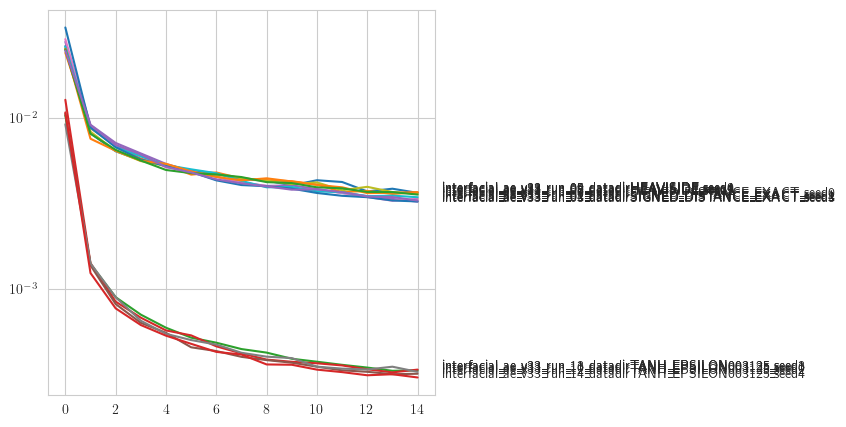

In [14]:

# Compare all the loss curves on one axis


name_to_loss = {}
completed_files = []

for f in files:
    try:
        name_to_loss[f] = read_loss_curve_from_file(f)
        completed_files.append(f)
    except FileNotFoundError:
        print(f'File {f} not found')
        pass


files = list(completed_files)

fig, ax = plt.subplots(figsize=(5, 5))
loss_component = 'Total'
for f, loss in name_to_loss.items():
    ax.plot(loss[loss_component], label=f.name)

    # Annotate name on the end of the curve
    ax.text(len(loss[loss_component]), loss[loss_component][-1], f.name)
    
#ax.legend()
ax.set_yscale('log')
plt.show()



In [15]:
# Functions to group the data by interface type and epsilon

def extract_interface_type(outdir):
    
    final_part = '_'.join(outdir.stem.split('_')[5:-1])

    str_to_type = {
        'datadirTANH_EPSILON00078125': InterfaceType.TANH_EPSILON,
        'datadirTANH_EPSILON0015625': InterfaceType.TANH_EPSILON,
        'datadirTANH_EPSILON003125': InterfaceType.TANH_EPSILON,
        'datadirTANH_EPSILON00625': InterfaceType.TANH_EPSILON,
        'datadirTANH_EPSILON0125': InterfaceType.TANH_EPSILON,
        'datadirTANH_EPSILON025': InterfaceType.TANH_EPSILON,
        'datadirHEAVISIDE': InterfaceType.HEAVISIDE,
        'datadirSIGNED_DISTANCE_EXACT': InterfaceType.SIGNED_DISTANCE_EXACT,
        'datadirSIGNED_DISTANCE_APPROXIMATE': InterfaceType.SIGNED_DISTANCE_APPROXIMATE,
    }

    return str_to_type[final_part]

def extract_epsilon(outdir):
    final_part = '_'.join(outdir.stem.split('_')[5:-1])
    
    str_to_epsilon = {
        'datadirTANH_EPSILON00078125': 0.0078125,
        'datadirTANH_EPSILON0015625': 0.015625,
        'datadirTANH_EPSILON003125': 0.03125,
        'datadirTANH_EPSILON00625': 0.0625,
        'datadirTANH_EPSILON0125': 0.125,
        'datadirTANH_EPSILON025': 0.25,
        'datadirHEAVISIDE': None,
        'datadirSIGNED_DISTANCE_EXACT': None,
        'datadirSIGNED_DISTANCE_APPROXIMATE': None,
    }
    
    return str_to_epsilon[final_part]


def get_model_path(outdir):
    return outdir / 'model-15.pt'


def get_dataset_path(interfacetype, epsilon):
    if interfacetype == InterfaceType.TANH_EPSILON:
        return pathlib.Path(f'/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON{epsilon}')
    elif interfacetype == InterfaceType.HEAVISIDE:
        return pathlib.Path(f'/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/HEAVISIDE')
    elif interfacetype == InterfaceType.SIGNED_DISTANCE_EXACT:
        return pathlib.Path(f'/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_EXACT')
    elif interfacetype == InterfaceType.SIGNED_DISTANCE_APPROXIMATE:
        return pathlib.Path(f'/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_APPROXIMATE')
    else:
        raise ValueError('Unknown interface type')
    

In [16]:
outdir_to_params = {}

for f in files:
    interfacetype = extract_interface_type(f)
    epsilon = extract_epsilon(f)
    model_path = get_model_path(f)
    dataset_path = get_dataset_path(interfacetype, epsilon)
    
    assert model_path.exists(), f'{model_path} does not exist'
    assert dataset_path.exists(), f'{dataset_path} does not exist'
    
    params = {
        'interface_type': interfacetype,
        'epsilon': epsilon,
        'model_path': model_path,
        'dataset_path': dataset_path
    }
    
    outdir_to_params[f] = params
    
# Sort

outdir_to_params = {key: outdir_to_params[key] for key in sorted(outdir_to_params.keys(), key=lambda x: x.stem)}

print(outdir_to_params)

{PosixPath('/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v33_run_00_datadirSIGNED_DISTANCE_EXACT_seed0'): {'interface_type': <InterfaceType.SIGNED_DISTANCE_EXACT: 2>, 'epsilon': None, 'model_path': PosixPath('/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v33_run_00_datadirSIGNED_DISTANCE_EXACT_seed0/model-15.pt'), 'dataset_path': PosixPath('/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_EXACT')}, PosixPath('/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v33_run_01_datadirSIGNED_DISTANCE_EXACT_seed1'): {'interface_type': <InterfaceType.SIGNED_DISTANCE_EXACT: 2>, 'epsilon': None, 'model_path': PosixPath('/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v33_run_01_datadirSIGNED_DISTANCE_EXACT_seed1/m

In [ ]:
# Run inference for all

for outdir, params in outdir_to_params.items():
    print(outdir)
    outfile = outdir / 'inference.npz'

    if outfile.exists():
        pass
    
    dataset = load_dataset(params['dataset_path'], max_num_samples=25_000, split='val')
    model = load_model(params['model_path'])
    gts, preds = run_inference(dataset, model, N=250)  # 500*9s = 4500s = 1.25 hours
    
    # Save outdir, preds, params, gt to disk, ready to be reloaded at evaluation time! 
    np.savez_compressed(outfile, gts=gts, preds=preds, **params)

/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v33_run_00_datadirSIGNED_DISTANCE_EXACT_seed0


INFO:src.datasets.volumetric_datasets:Found 59410 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_EXACT
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_EXACT/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=3750
INFO:src.datasets.volumetric_datasets:Loaded 3750 files for split val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_EXACT/2023-05-12-09-22-Folder_839_Restart_002_0.467945_patch_31.npz
INFO:src.datasets.volumetric_datasets:Generated 3750 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Si

Loading model to device: mps
Running inference on device: mps


  0%|          | 0/250 [00:00<?, ?it/s]/Users/murray/miniconda3/envs/mfe/lib/python3.12/site-packages/torch/nn/functional.py:4538: UserWarning: The operator 'aten::upsample_nearest3d.vec' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch._C._nn.upsample_nearest3d(input, output_size, scale_factors)
  3%|▎         | 8/250 [00:08<04:08,  1.03s/it]

In [7]:
from tqdm import tqdm


# Go over each file, and load predictions, compute metrics from each volume

def filename_to_plot_label(filename):
    final_part = '_'.join(filename.stem.split('_')[5:-1])

    str_to_label = {
        'datadirTANH_EPSILON00078125': 'Tanh 1/128',
        'datadirTANH_EPSILON0015625': 'Tanh 1/64',
        'datadirTANH_EPSILON003125': 'Tanh 1/32',
        'datadirTANH_EPSILON00625': 'Tanh 1/16',
        'datadirTANH_EPSILON0125': 'Tanh 1/8',
        'datadirTANH_EPSILON025': 'Tanh 1/4',
        'datadirHEAVISIDE': 'Sharp',
        'datadirSIGNED_DISTANCE_EXACT': 'SDF',
        'datadirSIGNED_DISTANCE_APPROXIMATE': 'Approx. SDF',
    }

    return str_to_label[final_part]

outdir_to_metrics = {}

for outdir, params in outdir_to_params.items():
    print(outdir)
    outfile = outdir / 'inference.npz'
    data = np.load(outfile)
    
    gts = data['gts']
    preds = data['preds']
    
    # Convert to sharp interface
    interfacetype = params['interface_type']
    
    dices = []
    hds = []
    
    for gt, pred in tqdm(zip(gts, preds)):
        gt = get_phi_sharp(gt, interfacetype)
        pred = get_phi_sharp(pred, interfacetype)
        
        dice = dice_coefficient(gt, pred)
        dices.append(dice)
        
        hd = hausdorff_distance(gt, pred, level=0.5)
        hds.append(hd)
        
    print(np.mean(dices))
        
    outdir_to_metrics[outdir] = {
        'Dice': dices,
        'Hausdorff': hds,
        #'gts': gts,
        #'preds': preds
    }
    

/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v33_run_00_datadirSIGNED_DISTANCE_EXACT_seed0


50it [00:01, 43.68it/s]


0.8481821680582787
/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v33_run_01_datadirSIGNED_DISTANCE_EXACT_seed1


50it [00:01, 39.34it/s]


0.8992242842474224
/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v33_run_02_datadirSIGNED_DISTANCE_EXACT_seed2


50it [00:01, 38.69it/s]


0.888778794795794
/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v33_run_03_datadirSIGNED_DISTANCE_EXACT_seed3


50it [00:01, 37.19it/s]


0.8574233223527281
/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v33_run_04_datadirSIGNED_DISTANCE_EXACT_seed4


50it [00:01, 39.99it/s]


0.8420452897072885
/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v33_run_05_datadirHEAVISIDE_seed0


50it [00:01, 29.42it/s]


0.9495521897170909
/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v33_run_06_datadirHEAVISIDE_seed1


50it [00:01, 26.02it/s]


0.9502846925711853
/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v33_run_07_datadirHEAVISIDE_seed2


50it [00:01, 26.19it/s]


0.9580117688682948
/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v33_run_08_datadirHEAVISIDE_seed3


50it [00:01, 29.13it/s]


0.950598972634332
/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v33_run_09_datadirHEAVISIDE_seed4


50it [00:01, 25.35it/s]


0.9582012850692584
/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v33_run_10_datadirTANH_EPSILON003125_seed0


50it [00:01, 25.37it/s]


0.9498949459890649
/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v33_run_11_datadirTANH_EPSILON003125_seed1


50it [00:01, 25.57it/s]


0.9593870064984665
/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v33_run_12_datadirTANH_EPSILON003125_seed2


50it [00:01, 27.43it/s]


0.9562285795248817
/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v33_run_13_datadirTANH_EPSILON003125_seed3


50it [00:01, 25.21it/s]


0.9556286319955956
/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v33_run_14_datadirTANH_EPSILON003125_seed4


50it [00:01, 26.89it/s]

0.9623513780104622


In [8]:
# Sort by outdir

sorted_outdirs = sorted(outdir_to_metrics.keys(), key=lambda x: x.stem)

outdir_to_metrics = {key: outdir_to_metrics[key] for key in sorted_outdirs}



In [9]:
# Compute the mean of each metric

outdir_to_mean_metrics = {}

for outdir in outdir_to_metrics:
    metrics = outdir_to_metrics[outdir]
    outdir_to_mean_metrics[outdir] = {}

    for metric, vals in metrics.items():
         outdir_to_mean_metrics[outdir][metric] = np.nanmean(vals)


# Normalise the HDs

for outdir in outdir_to_mean_metrics:
    outdir_to_mean_metrics[outdir]['Hausdorff'] = outdir_to_mean_metrics[outdir]['Hausdorff'] / 64.0

print(outdir_to_mean_metrics)


{PosixPath('/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v33_run_00_datadirSIGNED_DISTANCE_EXACT_seed0'): {'Dice': np.float64(0.8481821680582787), 'Hausdorff': np.float64(0.3619766285323289)}, PosixPath('/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v33_run_01_datadirSIGNED_DISTANCE_EXACT_seed1'): {'Dice': np.float64(0.8992242842474224), 'Hausdorff': np.float64(0.17968542138984536)}, PosixPath('/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v33_run_02_datadirSIGNED_DISTANCE_EXACT_seed2'): {'Dice': np.float64(0.888778794795794), 'Hausdorff': np.float64(0.1289992089204192)}, PosixPath('/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v33_run_03_datadirSIGNED_DISTANCE_EXACT_seed3'): {'Dice': np.float64(0.8574233223527281), 'Hausdorff': np.float64(0.08885297842645004)}, PosixPath('/Us

In [10]:
# Now for each interface type print the standard deviation between the 5 seeds

from collections import defaultdict

# Group by interface type and epsilon
metrics_by_type = defaultdict(lambda: defaultdict(list))
labels_by_type = {}

for outdir, metrics in outdir_to_mean_metrics.items():
    # Extract interface and epsilon
    params = outdir_to_params[outdir]
    interface_type = params['interface_type']
    epsilon = params['epsilon']  # Could be None (for sharp, sdf, etc.)
    group_key = (interface_type, epsilon)

    # Get plot label for printing
    if group_key not in labels_by_type:
        labels_by_type[group_key] = filename_to_plot_label(outdir)

    for metric, mean_val in metrics.items():
        metrics_by_type[group_key][metric].append(mean_val)

# Now compute std dev (and print means and stds)
for group_key, all_metrics in metrics_by_type.items():
    label = labels_by_type[group_key]
    print(f'=== {label} ===')
    for metric, vals in all_metrics.items():
        vals = np.array(vals)
        print(f'  {metric}: mean={np.mean(vals):.5f}, std={np.std(vals, ddof=1):.5f} (N={len(vals)})')


=== SDF ===
  Dice: mean=0.86713, std=0.02540 (N=5)
  Hausdorff: mean=0.17633, std=0.10875 (N=5)
=== Sharp ===
  Dice: mean=0.95333, std=0.00438 (N=5)
  Hausdorff: mean=0.05618, std=0.00923 (N=5)
=== Tanh 1/32 ===
  Dice: mean=0.95670, std=0.00466 (N=5)
  Hausdorff: mean=0.06474, std=0.00488 (N=5)


In [11]:
from scipy import stats
import numpy as np

# This cell assumes metrics_by_type and labels_by_type are defined as in the previous solution

for group_key, all_metrics in metrics_by_type.items():
    label = labels_by_type[group_key]
    print(f'=== {label} ===')
    for metric, vals in all_metrics.items():
        vals = np.array(vals)
        n = len(vals)
        mean = np.mean(vals)
        std = np.std(vals, ddof=1)

        # 95% CI for mean using t-distribution
        if n > 1:
            tval = stats.t.ppf(0.975, df=n-1)
            ci_halfwidth = tval * std / np.sqrt(n)
            ci_low = mean - ci_halfwidth
            ci_high = mean + ci_halfwidth
            print(f'  {metric}: mean={mean:.5f}, std={std:.5f}, 95% CI=({ci_low:.5f}, {ci_high:.5f}), N={n}')
        else:
            print(f'  {metric}: mean={mean:.5f}, std=nan, 95% CI=nan (not enough samples), N={n}')

=== SDF ===
  Dice: mean=0.86713, std=0.02540, 95% CI=(0.83559, 0.89867), N=5
  Hausdorff: mean=0.17633, std=0.10875, 95% CI=(0.04130, 0.31136), N=5
=== Sharp ===
  Dice: mean=0.95333, std=0.00438, 95% CI=(0.94789, 0.95877), N=5
  Hausdorff: mean=0.05618, std=0.00923, 95% CI=(0.04472, 0.06764), N=5
=== Tanh 1/32 ===
  Dice: mean=0.95670, std=0.00466, 95% CI=(0.95091, 0.96248), N=5
  Hausdorff: mean=0.06474, std=0.00488, 95% CI=(0.05868, 0.07081), N=5
